## 4. Data modeling
---

### 4.0. Problem statement

We will build some models that can **classify the Air Quality Index of Vietnam (1-5)** using the given features. Solving this problem offers diverse benefits, informing health interventions, policies, and fostering global collaboration. Moreover, accurate forecasting serves as a crucial tool for addressing health, environmental, and societal challenges tied to air pollution, promoting a comprehensive and sustainable approach.

### 4.1. Import libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

### 4.2. Data preparation

In the collecting and pre-processing stages, the data are fully filled and consistent so they don't need to be processed much in this stage. Moreover, the only categorical feature in this data, which is `aqi`, is dropped for labelling so we don't need to make categorical attributes become quantitative. For some specific models, we only need to apply the `Z-score` or `Standard` scaler to fit the values of numerical attributes into [0, 1] range but we will use the scaler from the `sklearn` library with some techniques in the next step.Hence, in this stage, we just need to investigate the distribution of the label values to determine whether there is a bias in `aqi`. 

In [2]:
# Read data
df = pd.read_csv('../data/air_pollution.csv')

# Drop unrelated attributed and label of the problem 
X = df.drop(['location', 'date', 'aqi'], axis=1)

# Assign label
y = df['aqi']

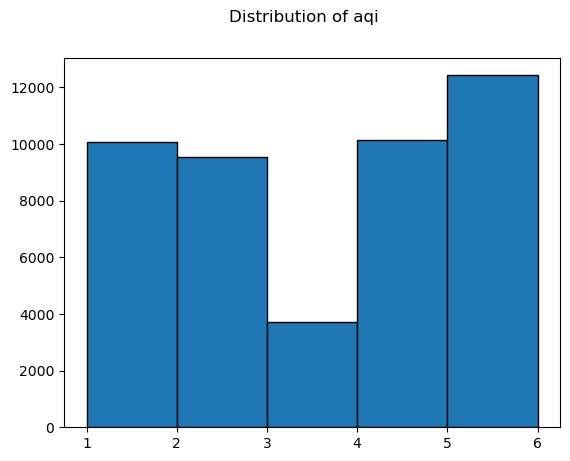

In [3]:
# Visualize the label distribution
plt.suptitle('Distribution of aqi')
plt.hist(y, bins=range(1, 7), edgecolor='black')
plt.show()

**Notes**
- In general, all the values in the label seems to be evenly distributed except the `aqi` at 3.
- So, in the next step when we split into training and testing dataset, we will split in the stratified style to remain the distribution of the original data.

In this problem, we will divide randomly the training and testing dataset into 6/4 ratio

In [4]:
# Split randomly train, test data set with 6/4 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

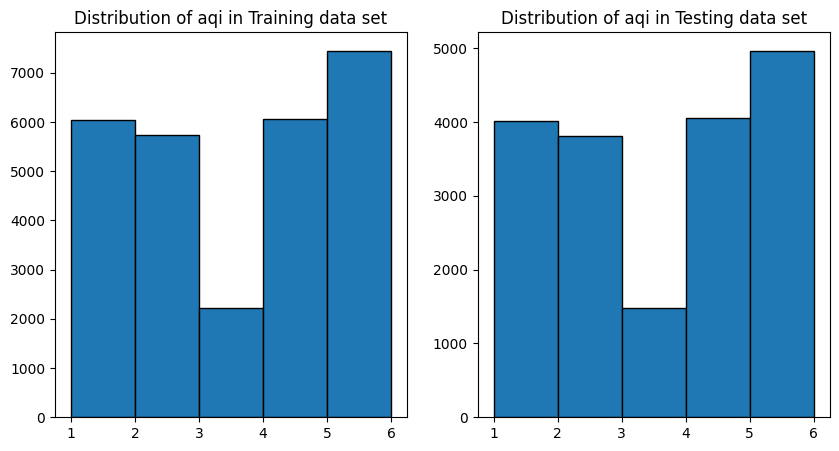

In [5]:
# Visualize the label distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
ax[0].set_title('Distribution of aqi in Training data set')
ax[0].hist(y_train, bins=range(1, 7), edgecolor='black')
ax[1].set_title('Distribution of aqi in Testing data set')
ax[1].hist(y_test, bins=range(1, 7), edgecolor='black')
plt.show()

**Notes**: 
- Looks like the distributions of both training and testing test are remain intact after being splitted, this may help the models generalize more effectively and reduce the bias when testing them. 

### 4.3. Create and initiate models

- We will use 5 models including `Naive Bayes`, `Decision Tree`, `K-Nearest Neighbours`, `SVM` and `Random Forest` to modelling our problem and all of that are used from the `sklearn` library instead of building from scratch.
- The metrics used for our multiclass classification problem is `accuracy`
- For each model, we'll use `Pipeline`, which is used to assemble several steps that can be cross-validated together while setting different parameters, to facilitate the cross-validating and fitting training data process. Depending on different models, we may use different `Pipelines` or, possibly, a `scaler` associated with that. More specifically, in `KNN` and `SVM` model, we need to scale our data to [0, 1] to accelerate our model when training our data, other models like `Naive Bayes` or `Decision Tree` don't need to be scaled because it doesn't affect much to the overall perfomance.

In [6]:
# Initializing models

# Naive Bayes
nb_clf = Pipeline(
        [('clf', GaussianNB())]
)

# K-Nearest Neighbours with Z-score scaler
knn_clf = Pipeline(
    [('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())]
)

# SVM with Z-score scaler
svm_clf = Pipeline(
    [('scaler', StandardScaler()),
    ('clf', SGDClassifier())]
)

# Decision Tree
dt_clf = Pipeline(
        [('clf', DecisionTreeClassifier())]
)

# Random Forest
rf_clf = Pipeline(
        [('clf', RandomForestClassifier())]
)

Next, for each model, we will inititate appropriate hyperparameters associated with the model for fine-tuning. For instance, in the `Naive Bayes` model, we will adjust the `var_smoothing` parameter ranges in logspace from 0 to -9, or in `KNN` model, `n_neighbors` will be set from [5, 10] and the methods for major voting are either `uniform` or `distance`, etc.

In [7]:
# Initializing params for fine-tuning
params_NB = {'clf__var_smoothing': np.logspace(0,-9, num=10)}
params_KNN = {'clf__n_neighbors': range(5, 10), 'clf__weights': ('uniform', 'distance')}
params_SVM = {'clf__alpha': [0.00001, 0.0001, 0.001, 0.01]}
params_DT = {'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [None, 5, 10, 15, 20], 'clf__min_samples_split': [2, 3, 4], 'clf__min_samples_leaf': range(1, 4)}
params_RF = {'clf__n_estimators': [50, 75, 100], 'clf__criterion': ['gini', 'entropy']}

In this step, we will fine-tune by cross-validating using `GridSearchCV` from `sklearn` library, which is special structure that exhaustive search over specified parameter values for an estimator. This facilitate the validating process because it uses `StratifiedKFold` method to cross-validate a model to find an optimal set of given hyperparameter for the model. Additionally, It can return the testing and training score, which are also very helpful for the visualizing purpose. All the model will uses 5-fold to cross-validate the parameters.

In [8]:
# Fine-tuning all models
nb_clf = GridSearchCV(
                estimator=nb_clf, 
                param_grid=params_NB, 
                cv=5,
                scoring='accuracy',
                return_train_score=True)
knn_clf = GridSearchCV(
                estimator=knn_clf,
                param_grid=params_KNN,
                cv= 5,
                scoring='accuracy',
                return_train_score=True)
svm_clf = GridSearchCV(
                estimator=svm_clf,
                param_grid=params_SVM,
                cv= 5,
                scoring='accuracy',
                return_train_score=True)
dt_clf = GridSearchCV(
                estimator=dt_clf,
                param_grid=params_DT,
                cv= 5,
                scoring='accuracy',
                return_train_score=True)
rf_clf = GridSearchCV(
                estimator=rf_clf,
                param_grid=params_RF,
                cv= 5,
                scoring='accuracy',
                return_train_score=True)

### 4.4. Cross-validating and Evaluating models

In [9]:
# Helper functions
def show_classification_report(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred, labels=model.classes_, zero_division=0))
    
def show_confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

### Naive Bayes

              precision    recall  f1-score   support

           1       0.56      0.88      0.68      4017
           2       0.39      0.41      0.40      3817
           3       0.00      0.00      0.00      1484
           4       0.48      0.57      0.52      4060
           5       0.93      0.60      0.73      4968

    accuracy                           0.57     18346
   macro avg       0.47      0.49      0.47     18346
weighted avg       0.56      0.57      0.54     18346



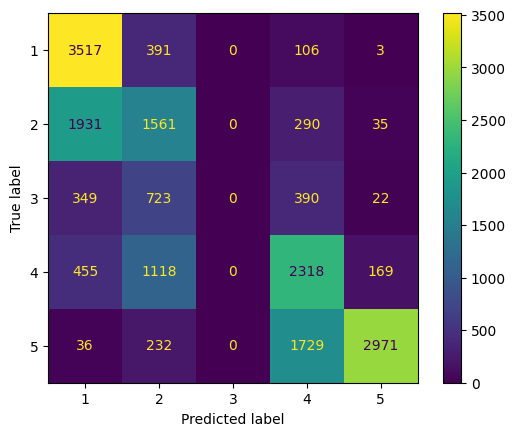

In [10]:
# Fitting model
nb_clf.fit(X_train, y_train)
# Metrics report on Naive Bayes
show_classification_report(nb_clf, X_test, y_test)
show_confusion_matrix(nb_clf, X_test, y_test)

**Comments**:
- Classification report:
    - The overall accuracy of the Naive Bayes classifier is ~55%, which is above average.
    - The precision and recall for each class are also relatively low, except for class 5, which has a high precision of ~92%. This means that the classifier is able to correctly identify most of the instances of class 5, but it is not very good at identifying instances of other classes.
    - The precision for class 3 (0.00) is very low, which means that the model is misclassifying examples from this class.
    - The weighted average F1-score is 54%, which is also below average. This means that the classifier is not very good at finding a good balance between precision and recall.
- Confusion matrix:
    - The predictions of the Naive Bayes classifier are all from class 1, 2, 4, 5 so the model struggle in predicting the class 3.
    - Moreover, the samples predicted vary from 4 classes so the probabilities when predict a new sample may be nearly equally distributed.

### K-Nearest Neighbours

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      4017
           2       0.73      0.82      0.77      3817
           3       0.50      0.30      0.38      1484
           4       0.81      0.86      0.84      4060
           5       0.96      0.93      0.95      4968

    accuracy                           0.83     18346
   macro avg       0.78      0.76      0.76     18346
weighted avg       0.83      0.83      0.83     18346



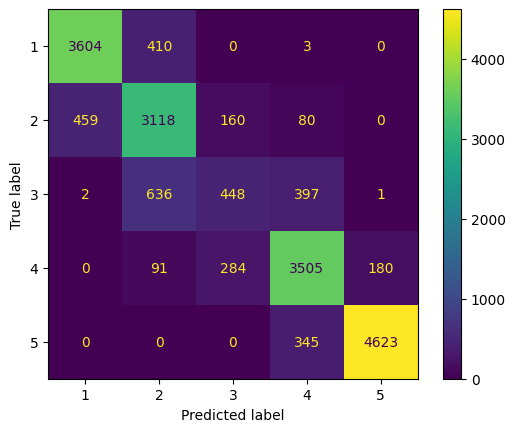

In [11]:
# Fitting model
knn_clf.fit(X_train, y_train)
# Metrics report on KNN
show_classification_report(knn_clf, X_test, y_test)
show_confusion_matrix(knn_clf, X_test, y_test)

**Comments**:
- Classification report:
    - The classifier is performing well overall, with an accuracy, weighted F1-score of 83%.
    - The precision and recall for most of classes are high (>80%), except for class 3, which has a poor recall of 32%.
    - The f1-score for class 3 (0.39) is low, which means that the model is struggling in predicting examples from this class.
- Confusion matrix:
    - Most of the samples from Class 1 and 5 are predicted accurately.
    - The classifier is missclassified when the samples are from class 2 or 3.

### Support Vector Machine

              precision    recall  f1-score   support

           1       0.90      0.99      0.95      3949
           2       0.45      0.69      0.54      3790
           3       0.09      0.01      0.02      1532
           4       0.58      0.39      0.47      4090
           5       0.96      1.00      0.98      4985

    accuracy                           0.71     18346
   macro avg       0.60      0.62      0.59     18346
weighted avg       0.68      0.71      0.69     18346



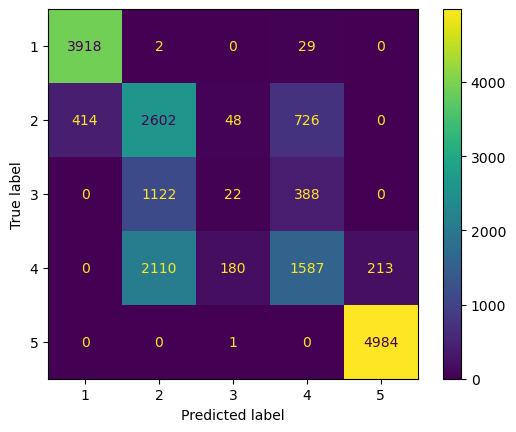

In [13]:
# Fitting data
svm_clf.fit(X_train, y_train)
# Metrics report on SVM
show_classification_report(svm_clf, X_test, y_test)
show_confusion_matrix(svm_clf, X_test, y_test)

**Comments**:
- Classification report:
    - The overall accuracy of the SVM classifier is good (~72%).
    - The precision and recall scores for individual classes are also decent, with most classes having precision and recall scores of over 80%. The only exception is class 3, which has a precision score of 17% and a recall score of 12%. This means that the classifier is not very good at predicting class 3 samples.
- Confusion matrix:
    - The model is performing well in predicting classes 1 and 5. It is also performing well in predicting class 4, but there are a significant number of false positives
    - However, The model is not performing as well in predicting class 3, with a significant number of misclassifications compared to the total of class 3 samples.

### Decision Tree

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3949
           2       1.00      0.99      1.00      3790
           3       0.98      0.96      0.97      1532
           4       0.99      0.99      0.99      4090
           5       0.99      1.00      1.00      4985

    accuracy                           0.99     18346
   macro avg       0.99      0.99      0.99     18346
weighted avg       0.99      0.99      0.99     18346



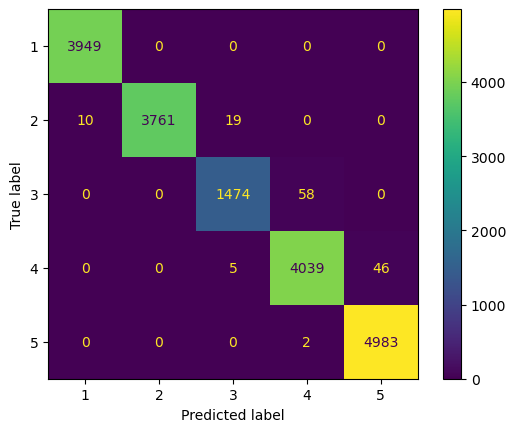

In [14]:
# Fitting data
dt_clf.fit(X_train, y_train)
# Metrics report on Decision Tree
show_classification_report(dt_clf, X_test, y_test)
show_confusion_matrix(dt_clf, X_test, y_test)

**Comments**:
- Classification report:
    - The overall accuracy of the Decision Tree classifier is 99%, which is nearly perfect.
    - The f1-scores for all classes are very high (nearly 100%) except from class 3 samples.
- Confusion matrix:
    - The predictions of the Decision Tree classifier are very precise, which has high number of true predictions applied for all classes.

### Random Forest

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3949
           2       1.00      0.99      0.99      3790
           3       0.99      0.96      0.97      1532
           4       0.99      0.99      0.99      4090
           5       0.99      1.00      1.00      4985

    accuracy                           0.99     18346
   macro avg       0.99      0.99      0.99     18346
weighted avg       0.99      0.99      0.99     18346



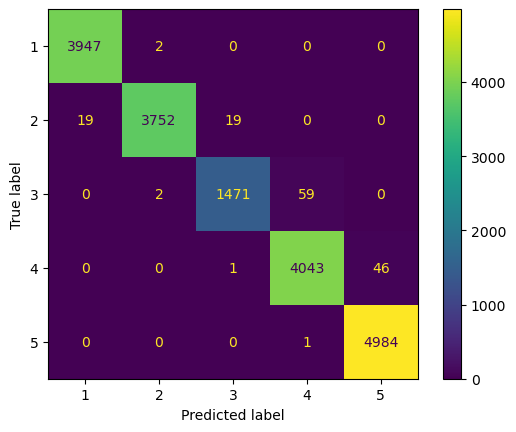

In [15]:
# Fitting data
rf_clf.fit(X_train, y_train)
# Metrics report on SVM 
show_classification_report(rf_clf, X_test, y_test)
show_confusion_matrix(rf_clf, X_test, y_test)

**Comments**:
- Classification report:
    - The overall accuracy of the Random Forest classifier is 99%, which is nearly perfect.
    - The f1-scores for all classes are very high (nearly 100%) except from class 3 samples.
- Confusion matrix:
    - The predictions of the Random Forest classifier are very precise, which has high number of true predictions applied for all classes.

### Cross-validating visualization for all models

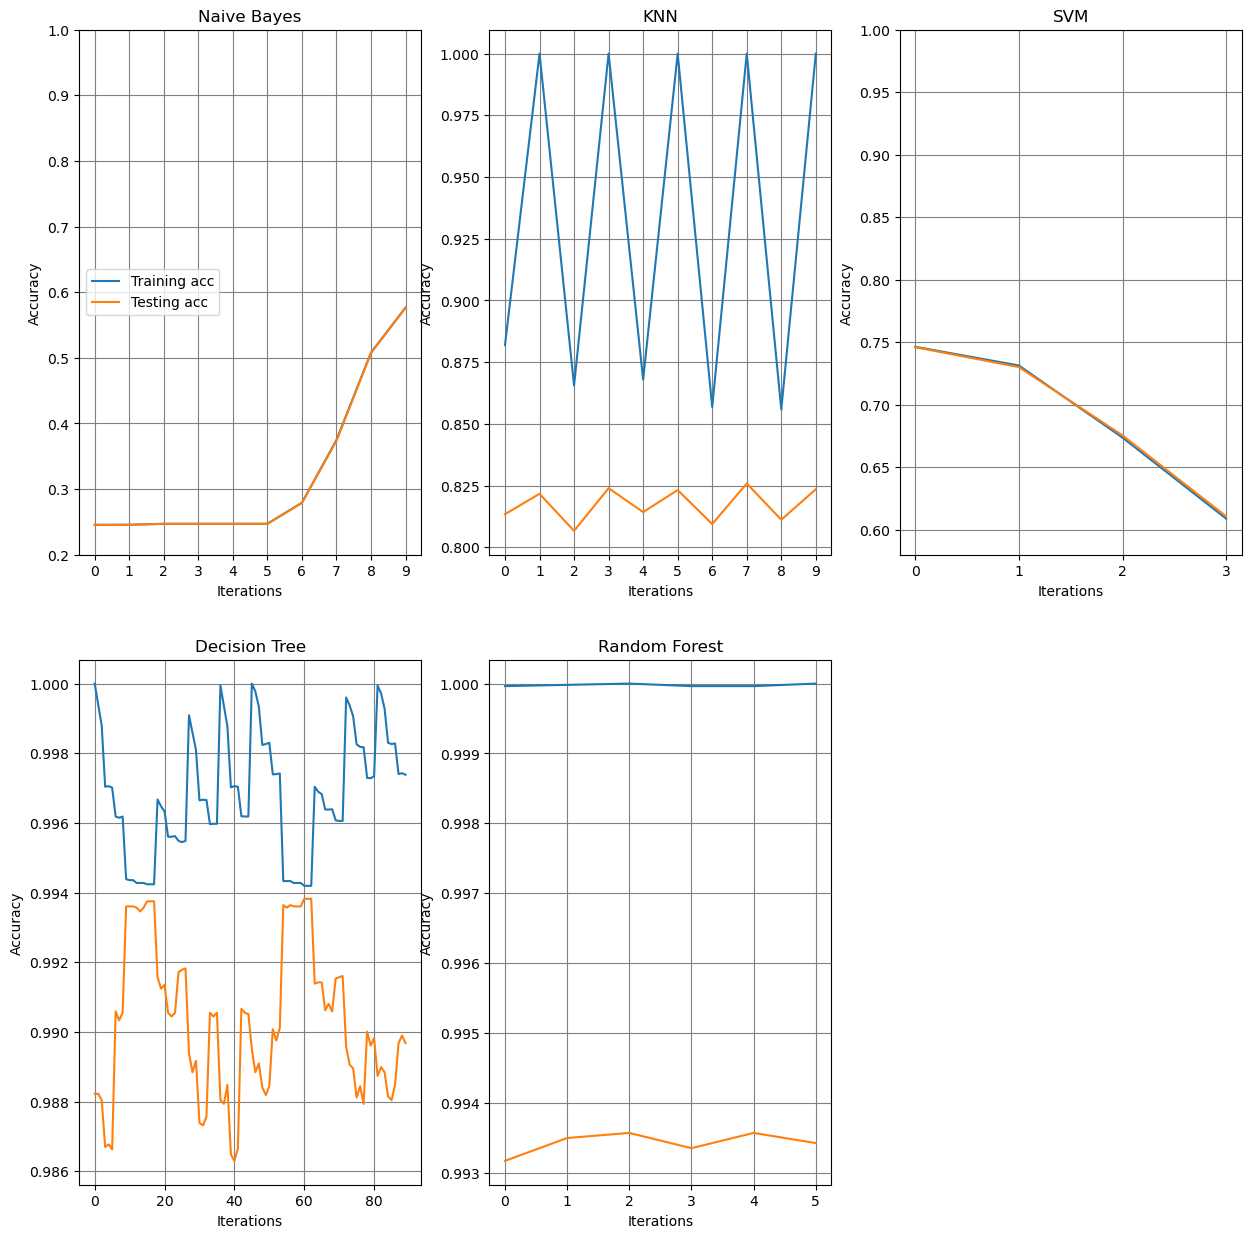

In [20]:
test = {'Naive Bayes' : nb_clf.cv_results_['mean_test_score'],
        'KNN': knn_clf.cv_results_['mean_test_score'],
        'SVM': svm_clf.cv_results_['mean_test_score'],
        'Decision Tree': dt_clf.cv_results_['mean_test_score'],
        'Random Forest': rf_clf.cv_results_['mean_test_score'],
        }
train = {'Naive Bayes' : nb_clf.cv_results_['mean_train_score'],
        'KNN': knn_clf.cv_results_['mean_train_score'],
        'SVM': svm_clf.cv_results_['mean_train_score'],
        'Decision Tree': dt_clf.cv_results_['mean_train_score'],
        'Random Forest': rf_clf.cv_results_['mean_train_score'],
        }
fix, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
models_name = list(test.keys())
for i in range(5):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.grid(color='gray')
    if i == 0:
        ax.set_ylim(0.2, 1)
        
    if i == 2:
        ax.set_ylim(0.58, 1)
        
    ax.plot(range(len(train[models_name[i]])), train[models_name[i]], label='Training acc')
    ax.plot(range(len(test[models_name[i]])), test[models_name[i]], label='Testing acc')
    
    if i == 0:
        ax.legend(loc='center left')
        
    if i != 3:
        ax.set_xticks(range(len(test[models_name[i]])))
        
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Accuracy')
    ax.set_title(models_name[i])
    
axes[-1, -1].set_visible(False)

**Conclusion**

- In general, most of our classification models achieve high accuracy on the training and testing dataset.

- However, the performance of the models on the testing dataset is more varied. Naive Bayes and SVM have the lowest accuracies on the testing dataset, at around 55% and 72%, respectively. Decision Tree, and Random Forest have much higher accuracies on the testing dataset, all above 98%. KNN also has decent accuracy which is about 83%, however, it is fluctuated on the training and testing set.

- This suggests that KNN may be overfitting the training dataset, meaning that they are learning the specific patterns in the training dataset too well and are not able to generalize to new data. Decision Tree, and Random Forest, on the other hand, are better able to generalize to new data, which is important for real-world applications.

- Among the given models, `Decision Tree` seems to be the best model for this problem due to its simplicity, speed and accuracy although its performance is not as stable as Random Forest's (but the difference is insignificant).